# Ray Tune Experiment Analysis 2023

In [1]:
pwd

'/p/project/raise-ctp2/cern/particleflow/nbs'

## Imports

In [2]:
import sys
sys.path.append("/p/project/raise-ctp2/cern/particleflow/mlpf")

from ray.tune import Analysis, ExperimentAnalysis

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rc_file
import pandas as pd
from matplotlib import rc_file
import pandas as pd
import seaborn as sns

In [4]:
from utils import count_skipped_configurations

In [5]:
ray_results_folder = "/p/project/raise-ctp2/cern/ray_results/"  # Main folder containing all ray experiments

In [6]:
ll "{ray_results_folder}"

total 2240
drwxr-sr-x 1840 wulff1 524288 Feb 20 09:50 asha_scikit_samples400/
drwxr-sr-x   11 wulff1  16384 Feb 16 16:18 clic_gnn_scan/
drwxr-sr-x    8 wulff1  16384 Feb 16 20:31 clic_transformer_bs_scan/
drwxr-sr-x   11 wulff1  16384 Feb 15 16:38 clic_transformer_scan/
drwxr-sr-x  458 wulff1 131072 Apr  4 09:38 clic_transformer_search_asha_hyperopt_n500/
drwxr-sr-x  502 wulff1 131072 Mar  1 13:36 clic_transformer_search_asha_n500/
drwxr-sr-x  234 wulff1  65536 Jun  1  2022 cmsgen_asha_epochs100/
drwxr-sr-x  202 wulff1  65536 Jun  7  2022 cmsgen_asha_epochs50/
drwxr-sr-x  471 wulff1 131072 Aug  3  2022 delphes_svr_dataset/
drwxr-sr-x   22 wulff1  16384 Sep 21  2022 event_loss_scan/
drwxr-sr-x   26 wulff1  16384 Sep 22  2022 event_loss_scan6/
drwxrwxrwx  112 wulff1  16384 May 29  2022 tune_result_dir/


In [7]:
# exp_dir = ray_results_folder + "clic_gnn_scan"  # chosen experiment
# exp_dir = ray_results_folder + "clic_transformer_scan"  # chosen experiment

exp_dir = ray_results_folder + "clic_transformer_search_asha_n500"  # chosen experiment
# exp_dir = ray_results_folder + "clic_transformer_search_asha_n500_v2"  # chosen experiment
exp_dir = ray_results_folder + "clic_transformer_search_asha_hyperopt_n500"  # chosen experiment
count_skipped_configurations(exp_dir)

Number of skipped configurations: 17


In [8]:
expanalysis = ExperimentAnalysis(exp_dir, default_metric="val_loss", default_mode="min")

In [9]:
# result_df = expanalysis.dataframe()
result_df = expanalysis.results_df.dropna(axis=0, how="all")

/p/project/raise-ctp2/cern/miniconda3/envs/tf2/lib/python3.9/site-packages/ray/tune/analysis/experiment_analysis.py:301: UserWarning: Dataframes will use '/' instead of '.' to delimit nested result keys in future versions of Ray. For forward compatibility, set the environment variable TUNE_RESULT_DELIM='/'
  warnings.warn(


In [10]:
def get_hp_df(result_df):
    return pd.concat([result_df["trial_id"], result_df.filter(regex="config/*")], axis=1)

In [11]:
def get_top_k_df(analysis, k):
    try:
        result_df = analysis.dataframe()
    except IndexError:
        result_df = analysis.results_df.dropna(axis=0, how="all")
    if analysis.default_mode == 'min':
        dd = result_df.nsmallest(k, analysis.default_metric)
    elif analysis.default_mode == 'max':
        dd = result_df.nlargest(k, analysis.default_metric)
    return dd

In [12]:
vars2titles = {
    'val_loss': 'Validation loss (a.u.)',
    'val_cls_loss': 'Validation classification loss (a.u.)',
    'val_reg_loss': 'Validation regression loss (a.u.)',
    'val_cls_acc_weighted': 'Validation classification accuracy',
    'val_jet_wd': 'Jet Wasserstein distance (a.u.)',
    'val_met_wd': 'MET Wasserstein distance (a.u.)',
}


def trial_id2logdir(trial_id, trial_dfs, verbose=True):
    for logdir in trial_dfs.keys():
        curr = trial_dfs[logdir]
        if "trial_id" in curr.keys():
            if curr["trial_id"][0] == trial_id:
                return logdir
        elif verbose:
            print(f"WARNING: no trial id in {logdir}")
    return None


def topk_summary_plot_v2(analysis, k, save=False, save_dir=None, skip=0, last=None, ylim=None, supress_labels=False, figsize=(12,11)):
    to_plot = [
        'val_loss', 'val_cls_loss', 'val_reg_loss', 'val_jet_wd', 'val_met_wd',
    ]

    dd = get_top_k_df(analysis, k)
    dfs = analysis.trial_dataframes

    fig, axs = plt.subplots(len(to_plot), 1, figsize=figsize, tight_layout=False, sharex=True)
    plt.tight_layout(rect=[0.05, 0.02, 0.9, 1.0])
    for irow, (var, ax_row) in enumerate(zip(to_plot, axs)):
        i_plot = 1
        if "logdir" in dd.keys():
            iterator = enumerate(dd["logdir"])
        else:
            iterator = enumerate(dd.index)
        for ii, key in iterator:
            if not "logdir" in dd.keys():
                key = trial_id2logdir(key, dfs, verbose=False)
            if var == 'val_reg_loss':
                values = sum([dfs[key]["val_{}_loss".format(l)].values for l in ["energy", "pt", "eta", "sin_phi", "cos_phi", "charge"]])
                values = values[skip:last]
            else:
                values = dfs[key][var][skip:last]

            iterations = dfs[key].index.values[skip:last]

            # curve labels
            if (irow == 0) and (not supress_labels):
                ax_row.plot(iterations, values, alpha=0.5, label="#{}".format(i_plot))
            else:
                ax_row.plot(iterations, values, alpha=0.5)

            ax_row.set_title(vars2titles[var])
            ax_row.grid(alpha=0.3)

            if ylim:
                ax_row.set_ylim(ylim[irow])
            i_plot += 1

    ax_row.set_xlabel("Epoch")
    fig.legend(loc="center right", bbox_to_anchor=(1, 0.5), )
    plt.figtext(0.89, 0.61, "Top trials", fontsize=18)
    fig.patch.set_facecolor('white')
    plt.subplots_adjust(left=None, bottom=None, right=0.8, top=None, wspace=None, hspace=None)
#    plt.suptitle("Top {} best trials according to '{}'".format(i_plot-1, analysis.default_metric))

    if save or save_dir:
        if save_dir:
            plt.savefig(str(Path(save_dir) / "topk_summary_plot_v2.pdf"))
        else:
            plt.savefig("topk_summary_plot_v2.pdf")
    else:
        plt.show()

In [13]:
tops = get_top_k_df(expanalysis, 10)

Couldn't read config from 79 paths


In [14]:
rc_file("my_matplotlib_rcparams")

Couldn't read config from 79 paths


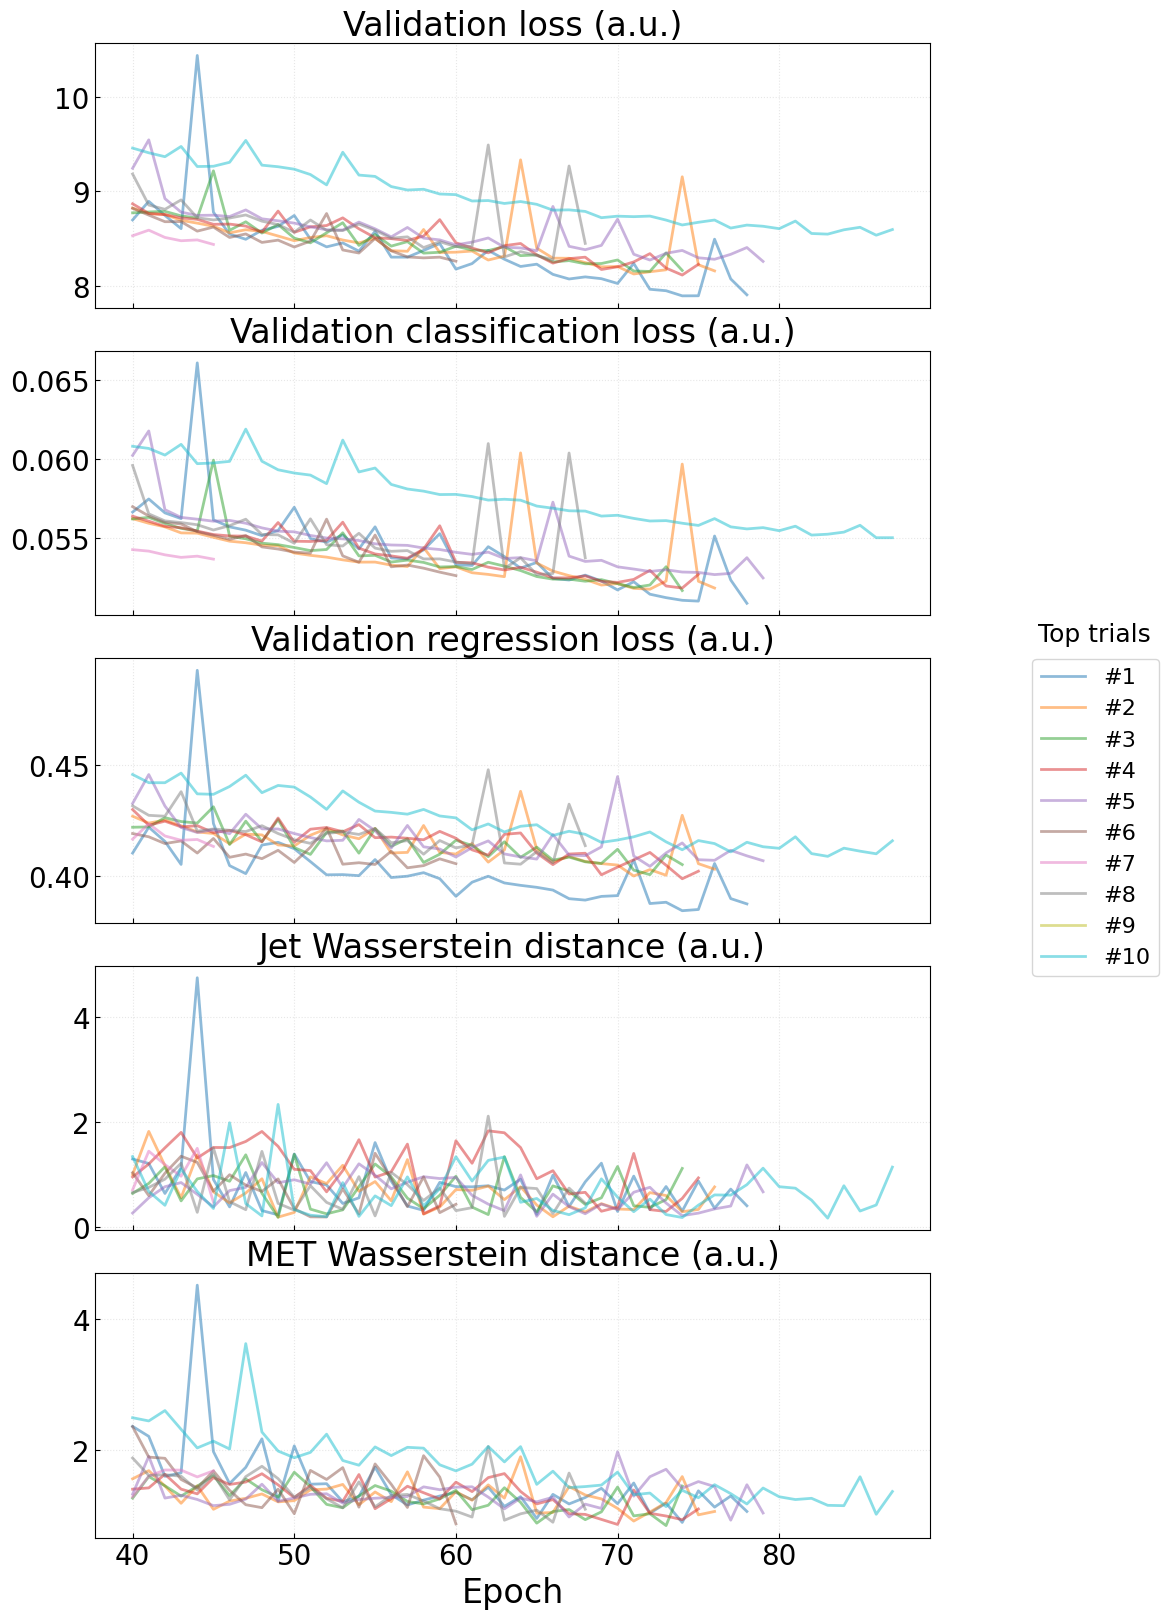

In [26]:
topk_summary_plot_v2(expanalysis, 10, skip=40, figsize=(12, 16))

In [16]:
best_config = expanalysis.get_best_config()
best_config

{'lr': 0.0001,
 'batch_multiplier': 10,
 'num_layers_encoder': 1,
 'num_layers_decoder_reg': 4,
 'num_layers_decoder_cls': 3,
 'hidden_dim': 256,
 'num_heads': 8,
 'num_random_features': 16,
 'out_hidden_dim': 256,
 'out_num_layers': 3}

In [17]:
expanalysis.best_dataframe["val_loss"].min()

7.893130302429199

In [18]:
def strip_config_str(key):
    return key.split("config/")[-1]


def style_df(df):
    cm_green = sns.light_palette("green", as_cmap=True)
    cm_red = sns.light_palette("red", as_cmap=True)

#    max_is_better = ['cls_acc_unweighted', 'val_cls_acc_weighted', 'val_cls_acc_unweighted']
    min_is_better = ['loss', 'cls_loss', 'val_loss', 'val_cls_loss', 'val_reg_loss', 'val_jet_wd', 'val_met_wd', 'val_jet_iqr', 'val_met_iqr']

#    max_is_better = ['val_cls_acc_weighted', 'val_cls_acc_unweighted']
#    min_is_better = ['val_loss', 'val_cls_loss', 'val_reg_loss']

    return (df.style
#      .background_gradient(cmap=cm_green, subset=max_is_better)
      .background_gradient(cmap=cm_red, subset=min_is_better)
#      .highlight_max(subset=max_is_better, props='color:black; font-weight:bold; background-color:yellow;')
      .highlight_min(subset=min_is_better, props='color:black; font-weight:bold; background-color:yellow;')
      .set_caption('Top {} trials according to {}'.format(len(df), expanalysis.default_metric))
      .hide_index()
      )


def summarize_top_k(analysis, k, save=False, save_dir=None):
    dd = get_top_k_df(analysis, k)

    val_reg_loss = sum([dd["val_{}_loss".format(l)].values for l in ["energy", "pt", "eta", "sin_phi", "cos_phi", "charge"]])

    summary = pd.concat([dd[[
                             "loss",
                             "cls_loss",
                             "val_loss",
                             "val_cls_loss",
                             ]],
                         pd.DataFrame({"val_reg_loss": val_reg_loss}, index=dd.index),
                         dd[[
                             'val_jet_wd', 'val_met_wd',
                             'val_jet_iqr', 'val_met_iqr',
                         ]],
                         dd.filter(regex=("config/*")),
#                        dd["logdir"],
                        ],
                         axis=1)
    summary.columns = [strip_config_str(col) for col in summary.columns]

    styled_summary = style_df(summary.iloc[:,:-1])

    if save or save_dir:
        if save_dir:
            styled_summary.to_excel(str(Path(save_dir) / "summary_table.xlsx"), engine='openpyxl')
        else:
            styled_summary.to_excel("summary_table.xlsx")
    return summary, styled_summary

In [19]:
summ, styled = summarize_top_k(expanalysis, 20)

Couldn't read config from 79 paths
/tmp/ipykernel_29706/2160184766.py:15: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  return (df.style


In [20]:
styled

loss,cls_loss,val_loss,val_cls_loss,val_reg_loss,val_jet_wd,val_met_wd,val_jet_iqr,val_met_iqr,batch_multiplier,hidden_dim,lr,num_heads,num_layers_decoder_cls,num_layers_decoder_reg,num_layers_encoder,num_random_features,out_hidden_dim
8.065343,0.051942,7.904021,0.050904,0.387452,0.404573,1.062308,0.082239,0.385882,10,256,0.000100,8,3,4,1,16,256
8.071668,0.051900,8.157811,0.051868,0.403123,0.763305,1.062090,0.081759,0.410481,5,64,0.000100,32,1,3,4,64,256
8.048681,0.051956,8.162509,0.051707,0.405181,1.114646,1.449827,0.085251,0.410977,5,64,0.000100,32,1,3,4,64,256
8.039186,0.051905,8.227382,0.052730,0.402213,0.934808,1.100437,0.087198,0.425654,5,64,0.000100,32,1,3,4,64,256
8.161339,0.052842,8.258201,0.052505,0.406932,0.669465,1.038919,0.082540,0.426209,5,64,0.000100,32,1,3,3,64,256
8.352124,0.053440,8.260261,0.052649,0.405598,0.432638,0.873255,0.084397,0.472430,10,128,0.000100,32,3,4,1,64,256
8.390086,0.053873,8.438155,0.053691,0.413366,0.473337,1.681418,0.086443,0.497151,5,64,0.000100,64,1,3,4,32,256
8.489000,0.055207,8.449428,0.053772,0.413728,0.454486,1.096725,0.091519,0.487125,5,64,0.000100,32,1,3,4,32,256
8.639980,0.055262,8.570541,0.054681,0.416874,0.732101,1.189451,0.092200,0.468493,10,128,0.000100,32,2,2,4,64,256
8.561970,0.055370,8.596179,0.055047,0.415937,1.139694,1.366436,0.087848,0.434211,10,64,0.000100,32,1,3,4,64,256


In [21]:
def plot_metric(logdir, trial_dfs, metric, skip=0, end=None, include_val=True, logdirs=None, save=False, xlim=None, ylim=None):
    key = metric
#    hp_df = get_hp_df(result_df)
    plt.figure()

    df = trial_dfs[logdir]
    plt.plot(df[key][skip:end], label="Training")
    if include_val:
        clr = plt.gca().lines[-1].get_color()  # get color of last plotted line
        plt.plot(df["val_" + key][skip:end], "--", color=clr, label="Validation")
    plt.legend()
    plt.ylabel(key)
    plt.xlabel("epoch")
    plt.grid(alpha=0.3)

    plt.xlim(xlim)
    plt.ylim(ylim)

    if save:
        print(f"Saving figs/{metric}.pdf")
        plt.savefig(f"figs/{metric}.pdf")


def monitor_plot(logdir, trial_dfs, skip=0, end=None, **kwargs):
    metrics_to_plot = ['loss', 'pt_loss', 'charge_loss', 'cls_loss', 'cos_phi_loss', 'energy_loss', 'eta_loss']
    metrics_to_plot_no_val = ['val_jet_iqr', 'val_jet_med', 'val_met_wd', 'val_met_iqr', 'val_met_med']

    for metric in metrics_to_plot:
        plot_metric(logdir, trial_dfs, metric, skip=skip, end=end, **kwargs)

    for metric in metrics_to_plot_no_val:
        plot_metric(logdir, trial_dfs, metric, include_val=False, skip=skip, end=end, **kwargs)


In [22]:
trial_dfs = expanalysis.trial_dataframes

In [23]:
pwd

'/p/project/raise-ctp2/cern/particleflow/nbs'

In [24]:
ll figs

total 192
-rw------- 1 wulff1 10646 Feb 24 09:32 charge_loss.pdf
-rw------- 1 wulff1  9506 Feb 24 09:32 cls_loss.pdf
-rw------- 1 wulff1  9686 Feb 24 09:32 cos_phi_loss.pdf
-rw------- 1 wulff1 10750 Feb 24 09:32 energy_loss.pdf
-rw------- 1 wulff1 10163 Feb 24 09:32 eta_loss.pdf
-rw------- 1 wulff1 11559 Feb 24 09:32 loss.pdf
-rw------- 1 wulff1  9743 Feb 24 09:32 pt_loss.pdf
-rw------- 1 wulff1 10923 Feb 24 09:32 val_jet_iqr.pdf
-rw------- 1 wulff1 10830 Feb 24 09:32 val_jet_med.pdf
-rw------- 1 wulff1 11050 Feb 24 09:32 val_met_iqr.pdf
-rw------- 1 wulff1 10587 Feb 24 09:32 val_met_med.pdf
-rw------- 1 wulff1 10781 Feb 24 09:32 val_met_wd.pdf


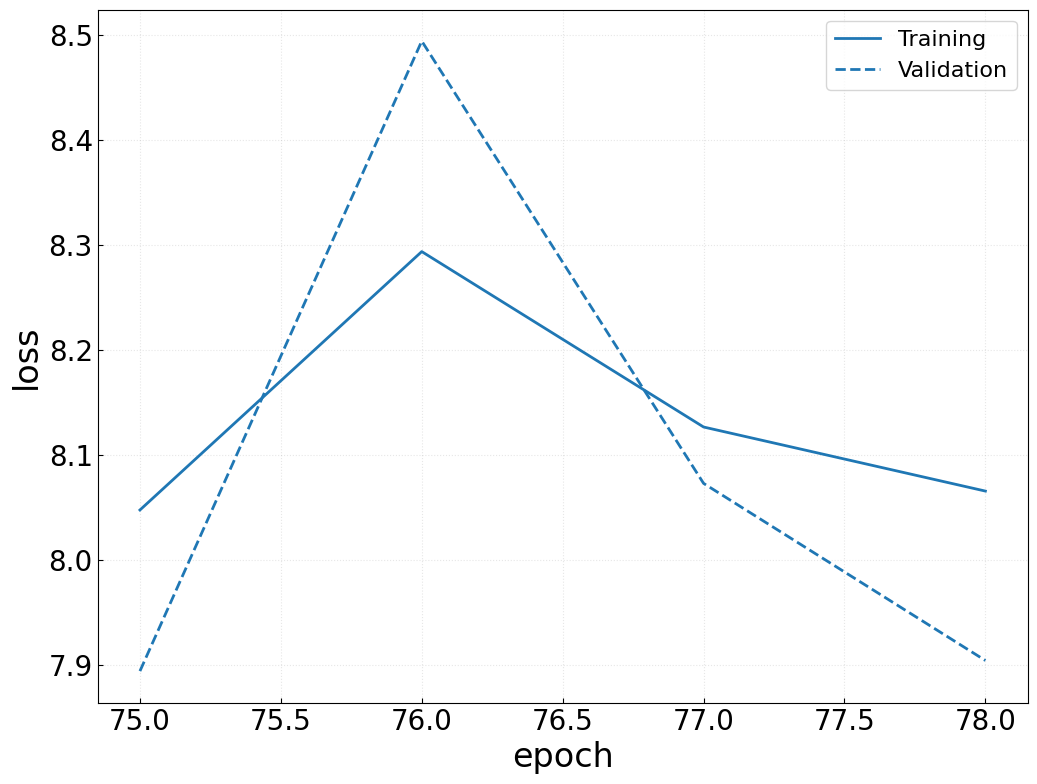

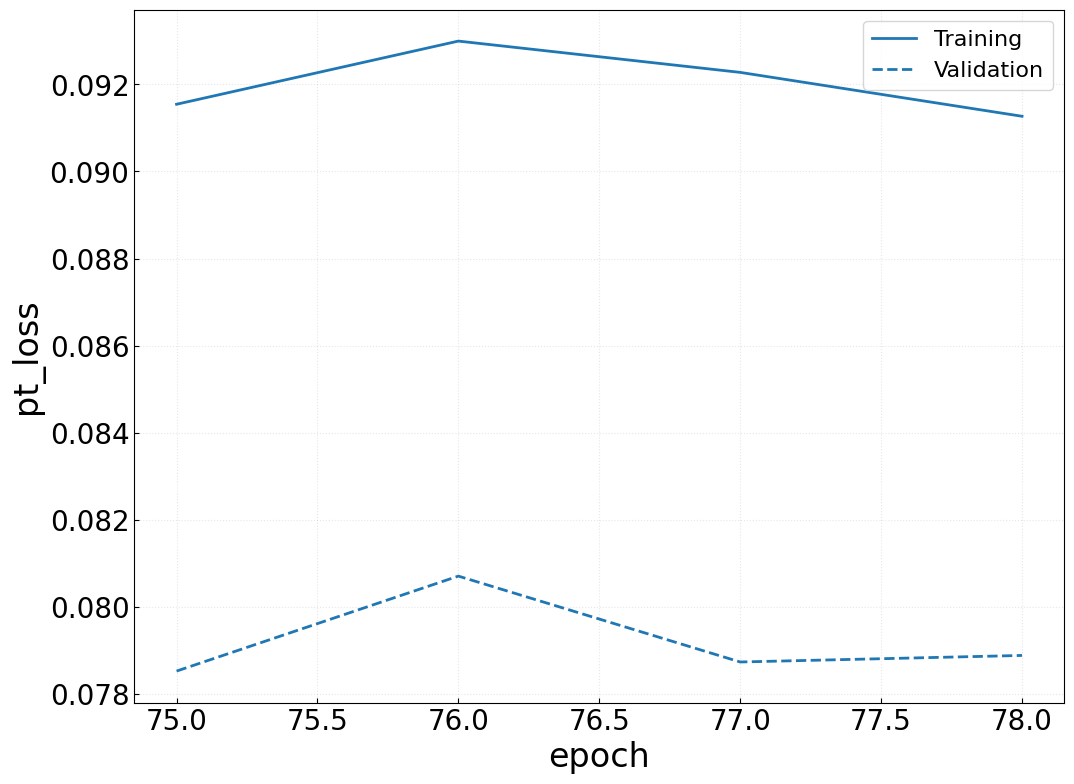

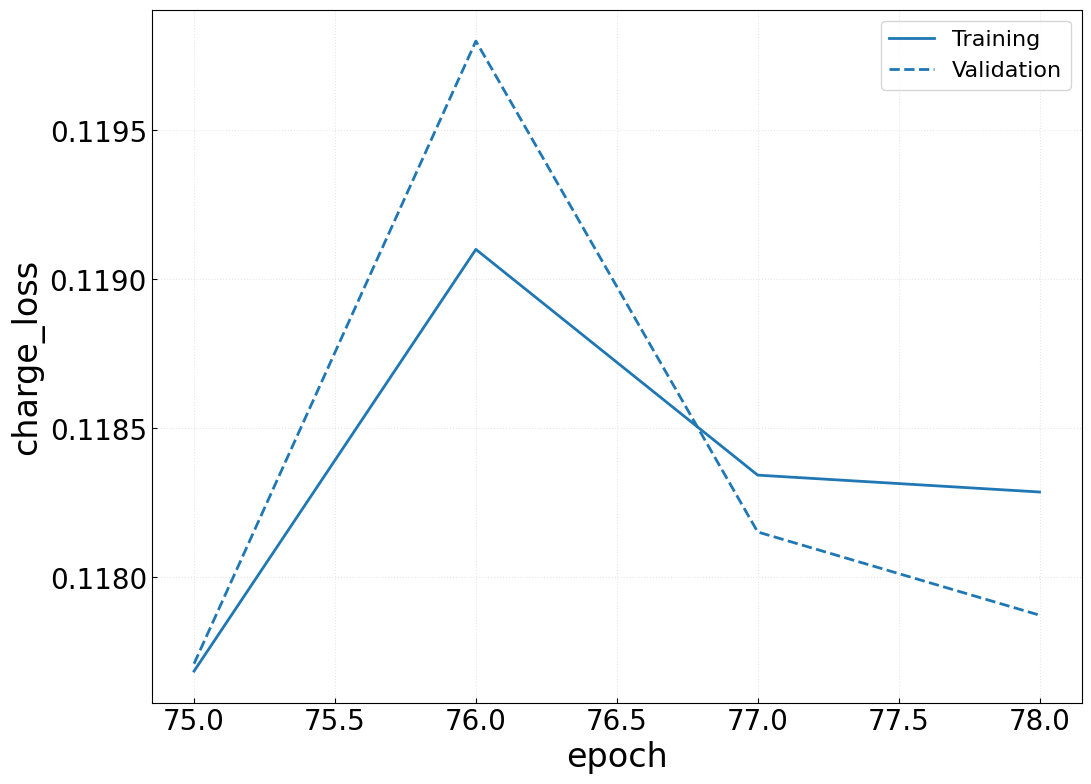

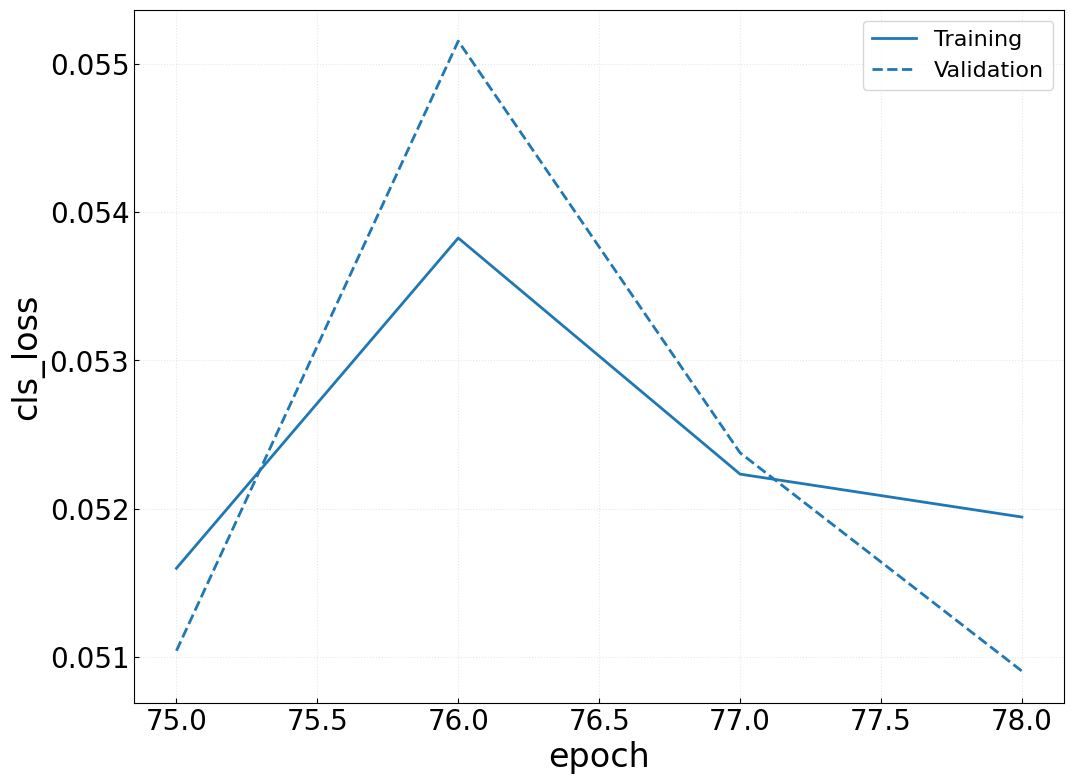

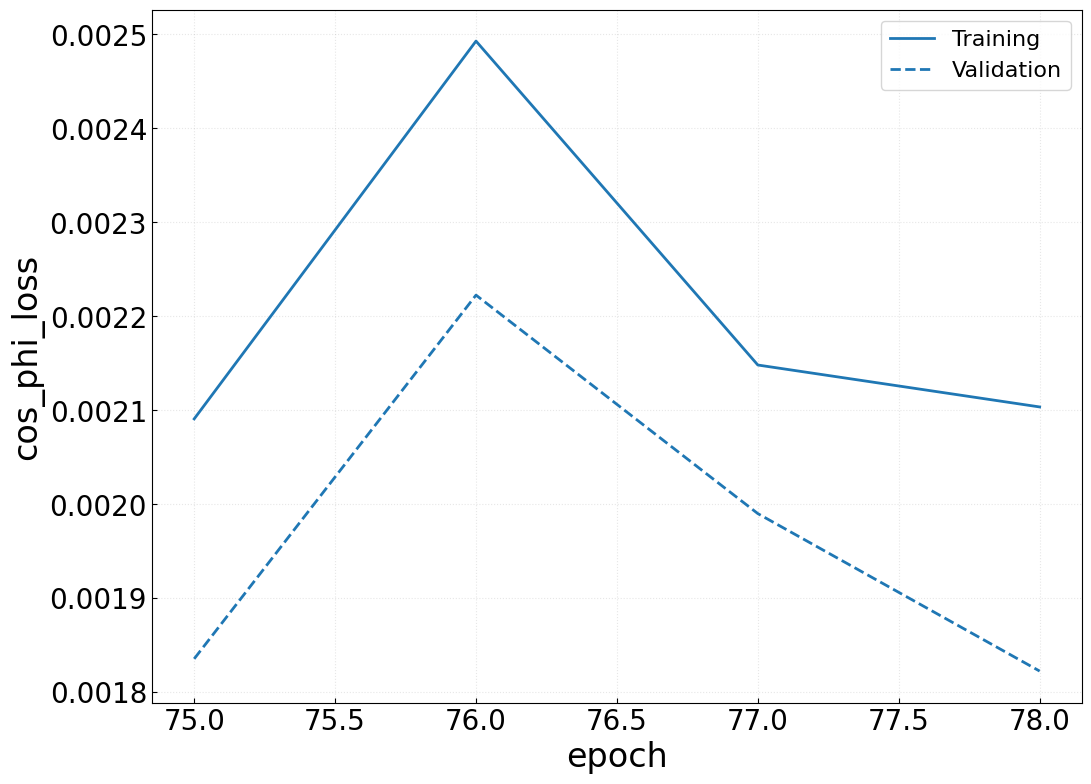

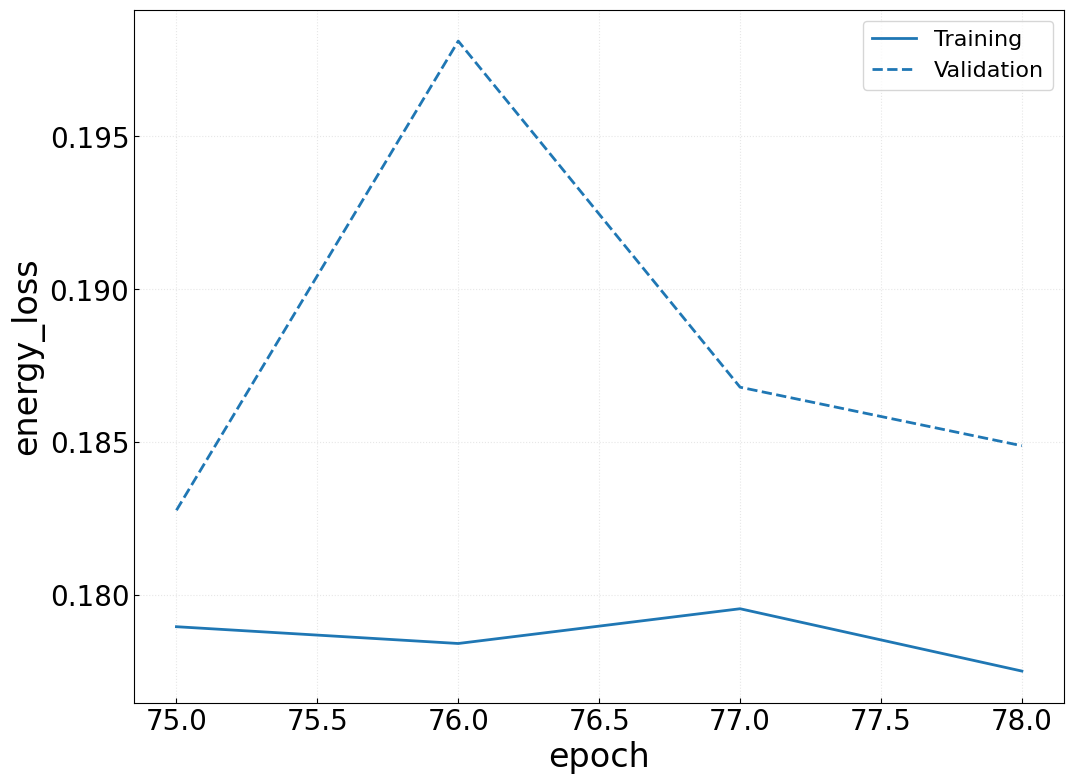

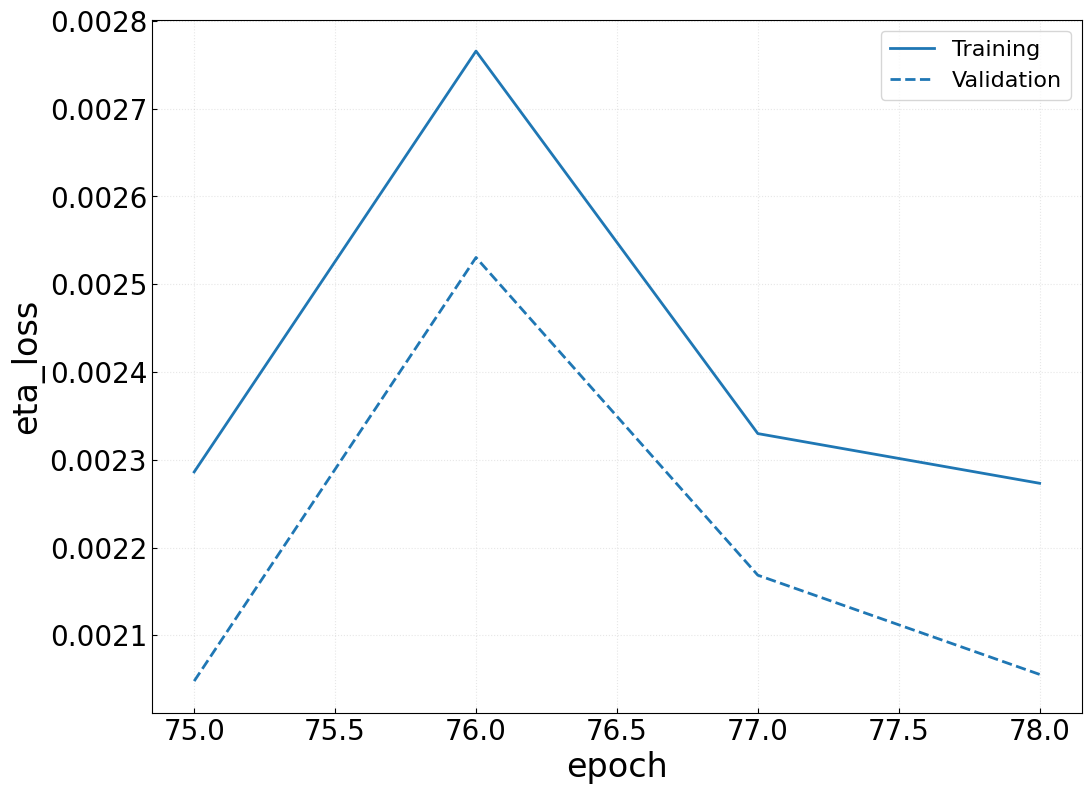

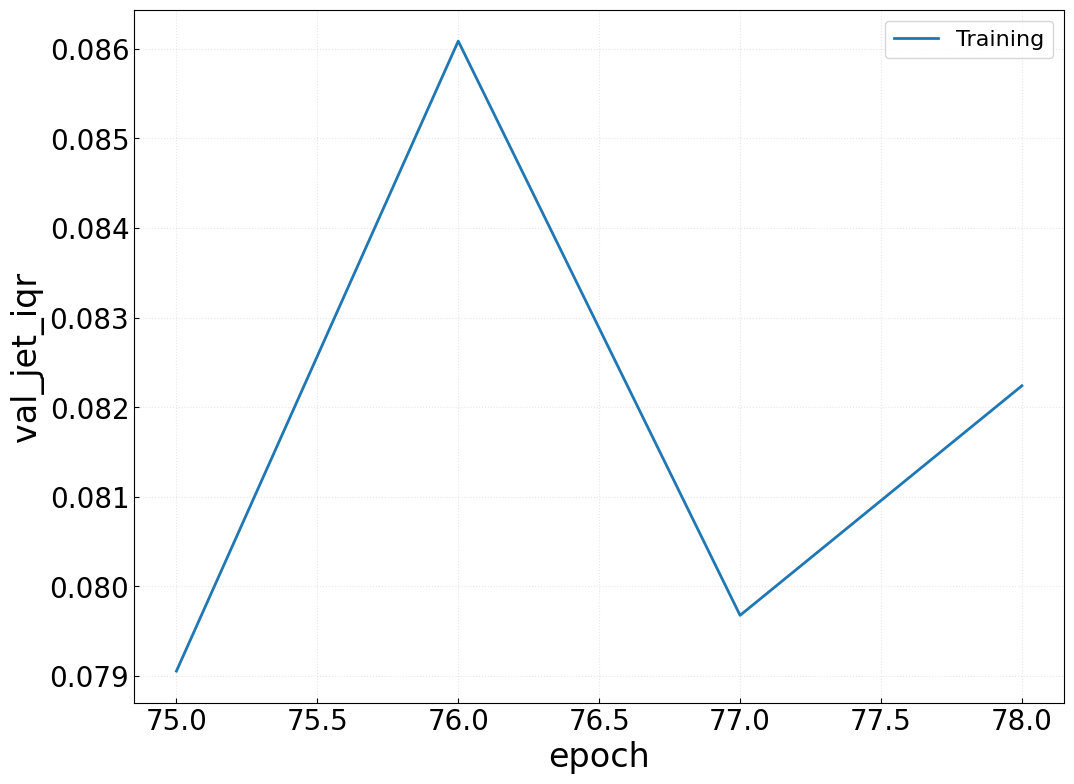

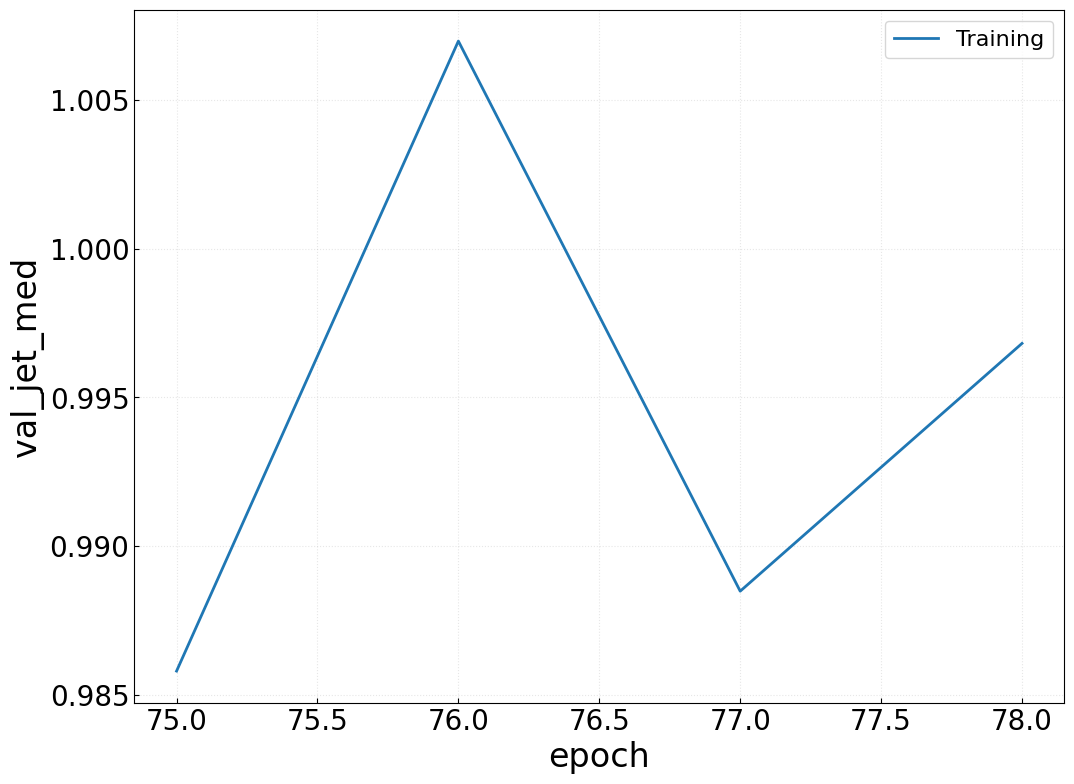

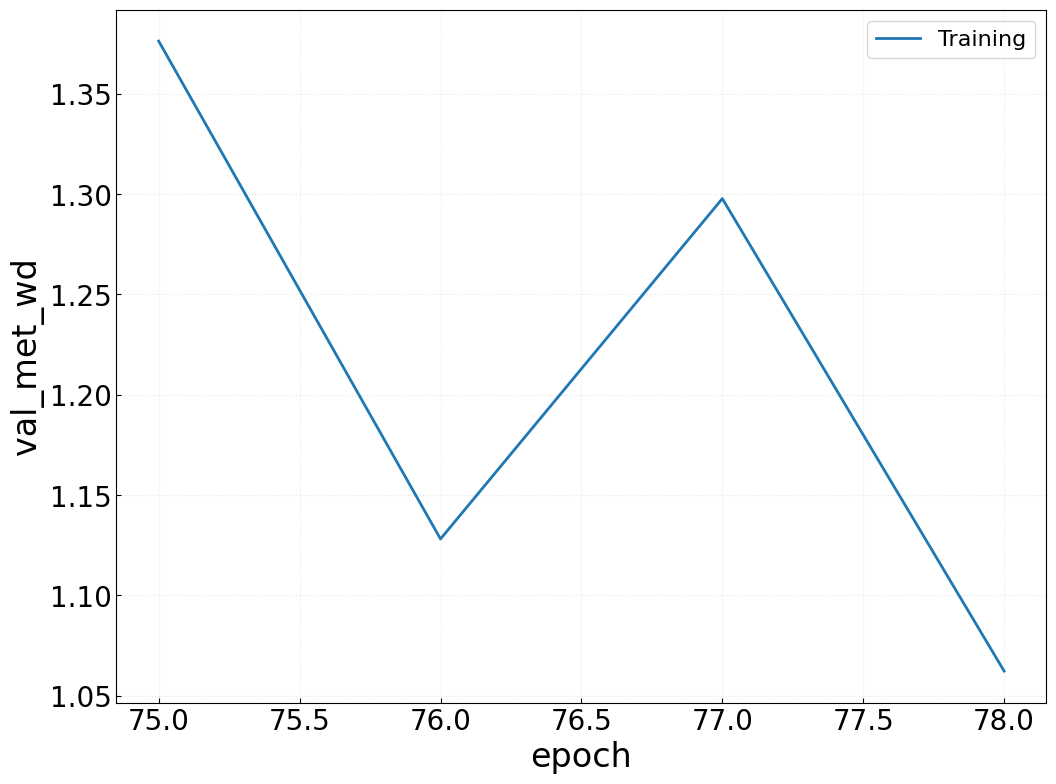

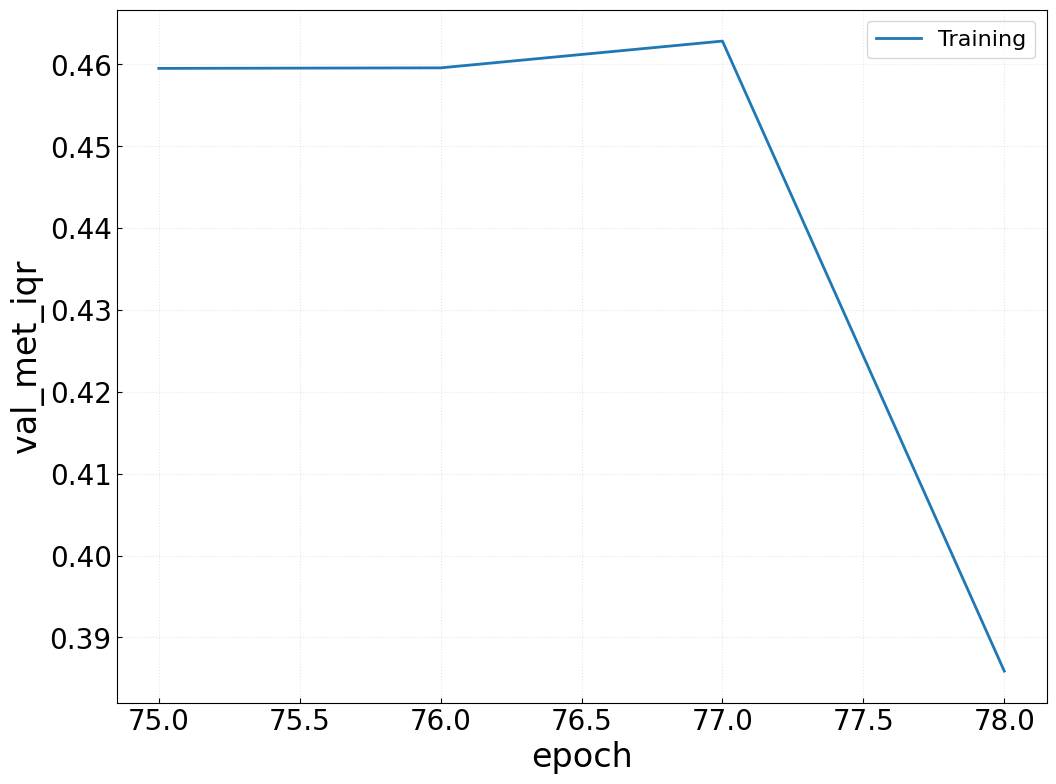

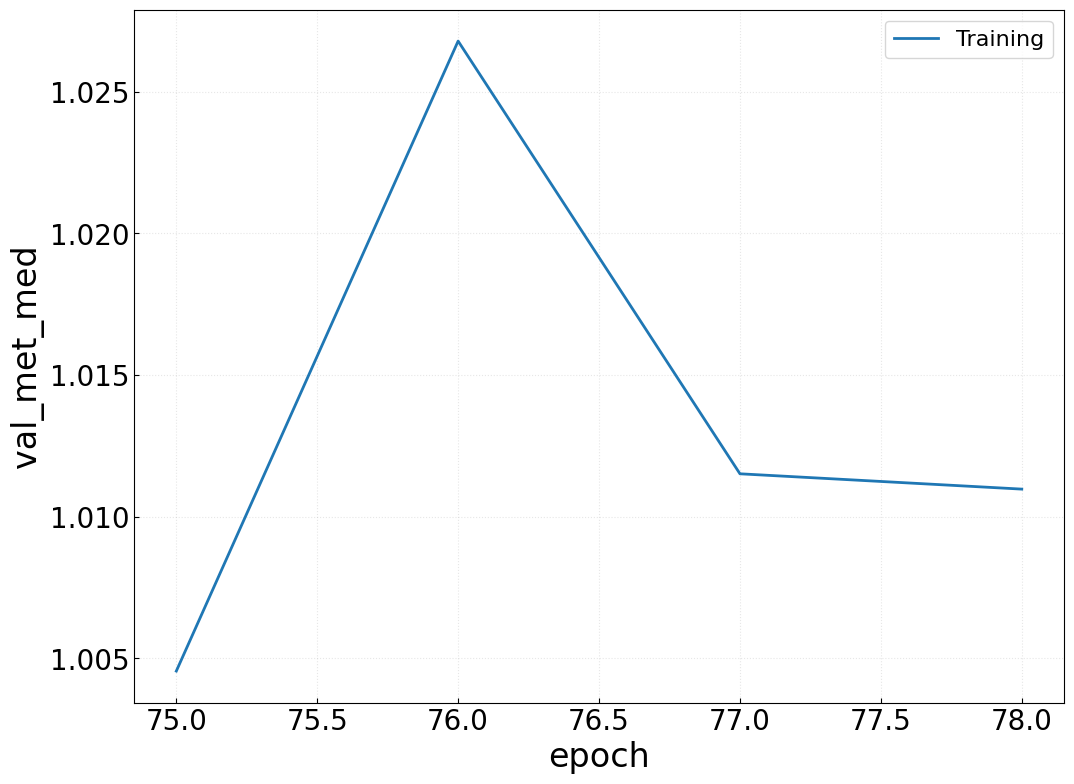

In [25]:
monitor_plot(expanalysis.get_best_logdir(), trial_dfs, skip=75, save=False, ylim=None)